# Day 3: Regressions in Julia

Julia is perhaps not a great replacement for R and Stata, which are specialty statistics packages designed so that certain kinds of model-fitting operations are efficient to express.

Still, Julia has a number of packages which are useful, and it is often helpful to do econometrics in Julia as part of a larger project of computation, estimation, and simulation. Many of the packages live in the [JuliaStats organization](https://github.com/JuliaStats/).

A few to point out

- [StatsBase](https://github.com/JuliaStats/StatsBase.jl) has basic statistical functions such as geometric and harmonic means, auto-correlations, robust statistics, etc.  
- [StatsFuns](https://github.com/JuliaStats/StatsFuns.jl) has a variety of mathematical functions and constants such as pdf and cdf of many distributions, softmax, etc.

Today we're going to focus on the [GLM](http://juliastats.github.io/GLM.jl/latest/) package.

In [16]:
using GLM, DataFrames, Random

x = randn(100)
y = 0.9 .* x + 0.5 * rand(100)  # note that rand() by itself is U(0,1), so the mean is 0.5
df = DataFrame(x = x, y = y)
ols = lm(@formula(y~x), df) # R-style notation

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.266012   0.0140449  18.94    <1e-33   0.238141   0.293884
x            0.894438   0.0166661  53.67    <1e-73   0.861365   0.927511
────────────────────────────────────────────────────────────────────────

To display the results in a useful tables for LaTeX and the REPL, use
[RegressionTables](https://github.com/jmboehm/RegressionTables.jl/) for output
similar to the Stata package esttab and the R package stargazer.

In [17]:
using RegressionTables
regtable(ols)
# regtable(ols,  renderSettings = latexOutput()) # for LaTex output


----------------------
                  y   
----------------------
(Intercept)   0.266***
               (0.014)
x             0.894***
               (0.017)
----------------------
N                  100
R2               0.967
----------------------



### Comparing models with an F-test

Comparisons between two or more linear models can be performed using the `ftest()` function, which computes an F-test between each pair of subsequent models and reports fit statistics:

In [22]:
using StableRNGs

df = DataFrame(y = (1:50).^2 .+ randn(StableRNG(1), 50), x = 1:50);

ols_lin = lm(@formula(y ~ x), df)

ols_sq = lm(@formula(y~x + x^2), df)

ftest(ols_lin.model, ols_sq.model)

F-test: 2 models fitted on 50 observations
─────────────────────────────────────────────────────────────────────────────────
     DOF  ΔDOF           SSR           ΔSSR      R²     ΔR²            F*   p(>F)
─────────────────────────────────────────────────────────────────────────────────
[1]    3        1731979.2266                 0.9399                              
[2]    4     1       40.7581  -1731938.4685  1.0000  0.0601  1997177.0357  <1e-99
─────────────────────────────────────────────────────────────────────────────────

### Probit regression

The `GLM` package supports different kinds of regressions using similar notation as R. Let's estimate a probit regression!

In [44]:
nDraws = 100

x = randn(StableRNG(1),nDraws)
eps = randn(StableRNG(2), nDraws)
y = ((x .+ eps) .> 0) .+ 0

df = DataFrame(x=x, y=y)

probit = glm(@formula(y ~ x), df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -0.015956    0.13978   -0.11    0.9091  -0.289919   0.258008
x             0.869547    0.177753   4.89    <1e-06   0.521158   1.21794
─────────────────────────────────────────────────────────────────────────

## A more complicated example

Let's explore a more fleshed-out example of an analysis and modelling workflow in Julia. This example comes from [Rohit Farmer](https://dataalltheway.com/posts/013-linear-regression/) and [Dhruva Sambrani](https://dataalltheway.com/posts/013-01-linear-regression-julia/index.html).

We're going to use “palmerpenguins: Palmer Archipelago (Antarctica) Penguin Data” by Allison Horst (Horst, Hill, and Gorman 2020). The simplified version of the PalmerPenguins dataset contains size measurements for 344 adult foraging Adélie, Chinstrap, and Gentoo penguins observed on islands in the Palmer Archipelago near Palmer Station, Antarctica. The original data were collected and made available by Dr. Kristen Gorman and the Palmer Station Long Term Ecological Research (LTER) Program (Gorman, Williams, and Fraser 2014).

First, let's load the data into Julia. For simplicity, we'll drop a few rows with missing data.

In [50]:
using PalmerPenguins
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true" # needed for downloading data without confirmation
data = dropmissing(DataFrame(PalmerPenguins.load()))

Row,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
,String15,String15,Float64,Float64,Int64,Int64,String7
1,Adelie,Torgersen,39.1,18.7,181,3750,male
2,Adelie,Torgersen,39.5,17.4,186,3800,female
3,Adelie,Torgersen,40.3,18.0,195,3250,female
4,Adelie,Torgersen,36.7,19.3,193,3450,female
5,Adelie,Torgersen,39.3,20.6,190,3650,male
6,Adelie,Torgersen,38.9,17.8,181,3625,female
7,Adelie,Torgersen,39.2,19.6,195,4675,male
8,Adelie,Torgersen,41.1,17.6,182,3200,female
9,Adelie,Torgersen,38.6,21.2,191,3800,male


### A bit about penguins

Ultimately, we're going to model the body mass of the penguin as a function of other elements of the penguin. One that particularly matters is the **culmen**, which is “the upper ridge of a bird’s beak” (definition from Oxford Languages).

![](https://dataalltheway.com/posts/013-linear-regression/images/culmen_depth.png)

In this simplified dataset, culmen length and depth are recorded as variables named `bill_length_mm` and `bill_depth_mm`.

### Exploratory Plots

Let's do some exploratory data visualization to see what we're working with. First, let's count the number of observations by species and sex.

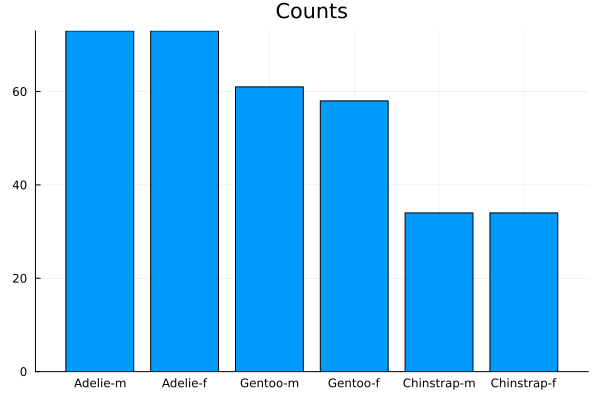

In [58]:
using Pipe
using Plots

g_data = @pipe data |>
    groupby(_, [:species, :sex]) |>
    combine(_, :sex=>length=>:counts) |>
    unique
labels = map(zip(g_data[!, :species], g_data[!, :sex])) do (i,j)
    "$(i)-$(j[1])"
end
plot(labels, g_data[!, :counts], st=:bar, title="Counts", label=false)

With some Julia magic, we can make a a couple of nice plots showing the correlation between the various predictors and the variable of interest (body mass). This gets a little fancy because we're doing quick-and-dirty linear fits for each species.

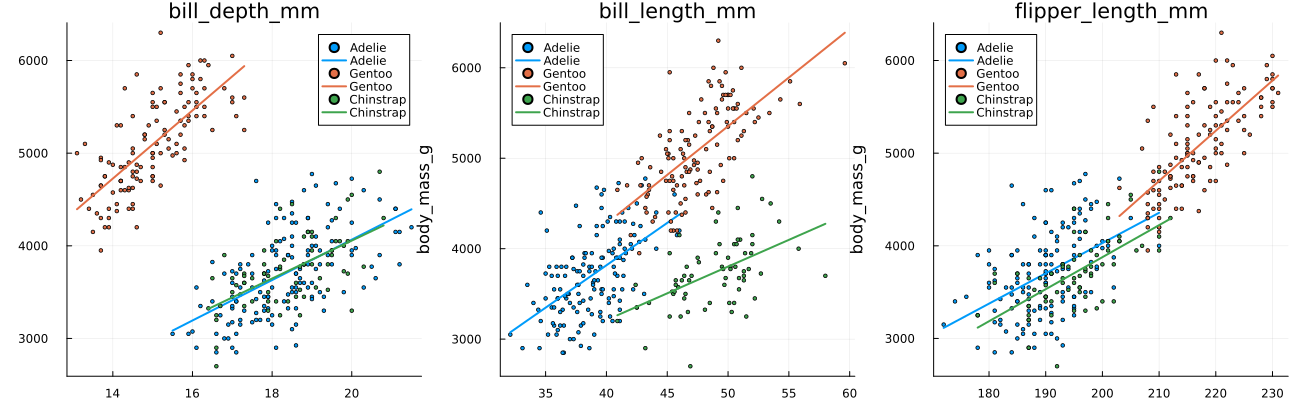

In [ ]:
using LsqFit

@. linear_model(x, p) = p[1]*x + p[2]       # define a simple linear model y = bx + a

function plot_corrs(data, variable)
    p = plot(title=variable)                # set up a plot object
    ds1 = @pipe data |>                     # group the dataframe by species, focusing on the variable of interest
        _[!, [:species, variable, :body_mass_g]] |>
        groupby(_, :species)

    for sdf in ds1      # loop through the species in the list
        color = palette(:auto)[length(p.series_list)÷2 + 1]
        scatter!(sdf[!, variable], sdf[!, :body_mass_g],    # add a scatterplot to the plot object
            label=sdf[!, :species][1],
            markersize=2,
            color=color
        )
        fit = curve_fit(    # create a best fit line
            linear_model,
            sdf[!, variable], sdf[!, :body_mass_g], [0., 0.],
        )
        plot!(          # add the best fit line to the plot object
            sdf[!, variable],
            linear_model(sdf[!, variable], fit.param),
            label=sdf[!, :species][1],
            lw = 2,
            color=color
        )
    end
    return p
end

plot(
    plot_corrs(data, :bill_depth_mm),
    plot_corrs(data, :bill_length_mm),
    plot_corrs(data, :flipper_length_mm),
    layout=(1,3),
    size=(1300, 400),
    ylabel="body_mass_g"
)

### Models

Utilizing the dataset prepared above, we will build two models with slightly different predictor sets for inferential modeling, i.e., to understand how the different sets of predictors influence the fitting of the model (model the complexity of data) and what predictors are more informative than the others.

#### Model 1

In the first model, we will regress body mass in grams, i.e., the `body_mass_g` column in the DataFrame on three numeric predictors `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, and one categorical feature `sex` (female and male).

In [66]:
fit_model_1 = lm(
    @formula(body_mass_g ~ bill_depth_mm + bill_length_mm + flipper_length_mm + sex),
    data,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

body_mass_g ~ 1 + bill_depth_mm + bill_length_mm + flipper_length_mm + sex

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                         Coef.  Std. Error      t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)        -2288.46      631.58     -3.62    0.0003  -3530.92    -1046.01
bill_depth_mm        -86.0882     15.5698   -5.53    <1e-07   -116.718     -55.4589
bill_length_mm        -2.32868     4.6843   -0.50    0.6194    -11.5437      6.88638
flipper_length_mm     38.8258      2.44776  15.86    <1e-41     34.0105     43.6411
sex: male            541.029      51.7098   10.46    <1e-21    439.304     642.753
────────────────────────────────────────────

If we call `ftest()` with just this model, it will compare it to the null model.

In [68]:
ftest(fit_model_1.model)

F-test against the null model:
F-statistic: 381.30 on 333 observations and 4 degrees of freedom, p-value: <1e-99

We can also generate some diagnostic plots which will help us assess the performance of the model and the assumptions that we made.

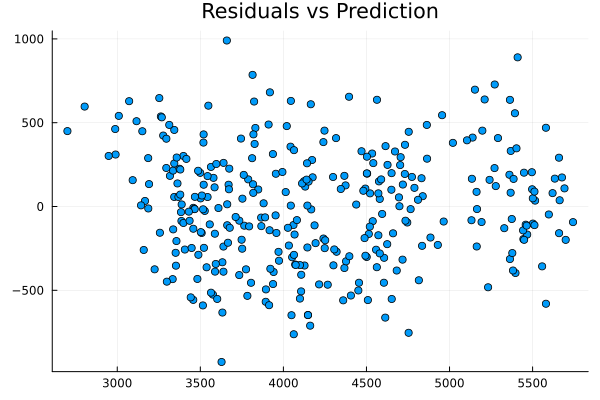

In [72]:
using Statistics
x = predict(fit_model_1)
y = residuals(fit_model_1)
ystd = (y .- mean(y))/std(y);
scatter(x, y, title="Residuals vs Prediction", label=false)

This plot shows the residuals (vertical axis) plotted against the predicted/fitted values (horizontal axis). It helps you examine the assumption of constant variance (homoscedasticity). In this plot, you would ideally want to see a random scatter of points with no discernible pattern or trend, indicating that the assumption of constant variance is reasonable.

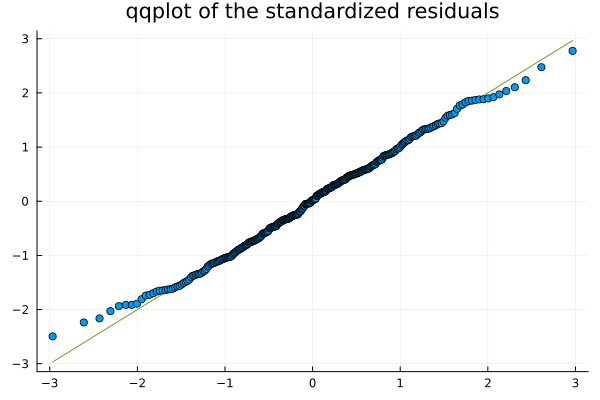

In [76]:
using StatsPlots
qqplot(Normal(), ystd, title="qqplot of the standardized residuals")

This plot assesses the assumption of normality of residuals. It compares the standardized residuals to the quantiles of a normal distribution. If the points lie approximately along a straight line, it suggests that the residuals are normally distributed. Deviations from the straight line indicate departures from normality.

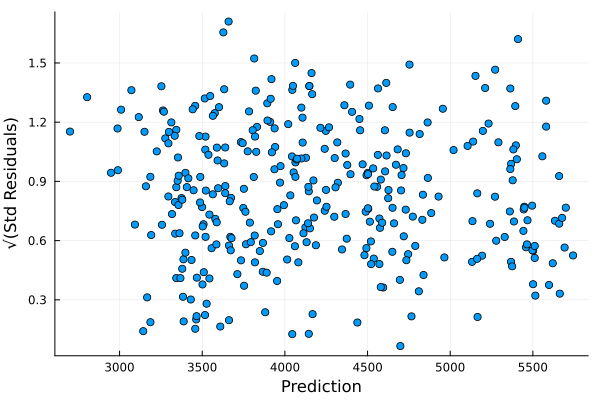

In [78]:
scatter(x, sqrt.(abs.(ystd)), ylabel="√(Std Residuals)", xlabel="Prediction", label=false)

This plot, also known as the spread-location plot, is used to evaluate the assumption of constant variance (homoscedasticity) similarly to the Residuals vs. Fitted plot. However, it provides a different perspective by plotting the square root of the standardized residuals against the fitted values. A reasonably constant spread of points with no discernible pattern indicates homoscedasticity.

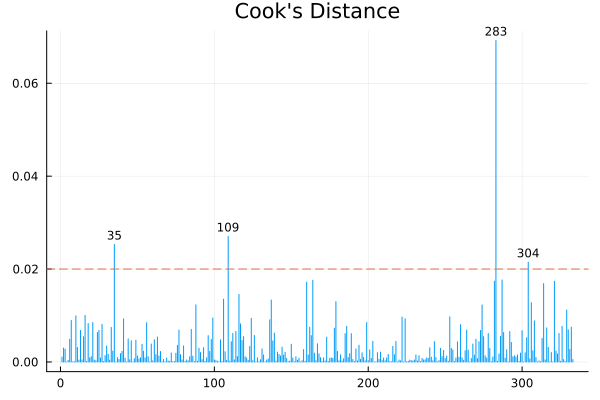

In [80]:
cdist = cooksdistance(fit_model_1)
plot(cdist, st=:sticks, title="Cook's Distance", label="")
high_dist = findall(>(0.02), cdist)
hist_dist_annots = map(high_dist) do i
    (i, cdist[i]+0.002, text(string(i), 8))
end
annotate!(hist_dist_annots)
hline!([0.02], linestyle=:dash, label=false)

Cook’s distance is a measure of the influence of each observation on the model fit. The plot shows the Cook’s distance values for each observation. Points with high Cook’s distance may have a considerable impact on the model and should be further examined.

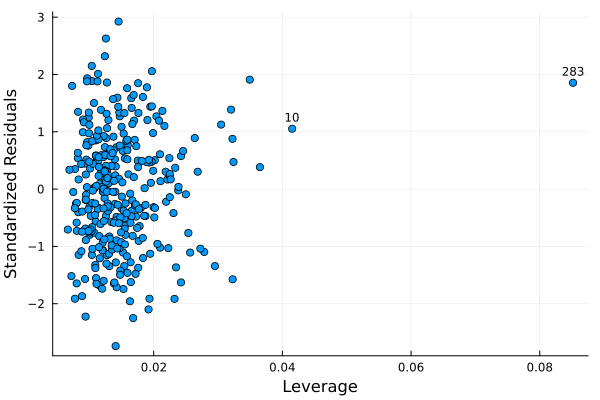

In [134]:
# generate leverage matrix
using Query
df = @from i in data begin
    @select {i.bill_length_mm, i.bill_depth_mm, i.flipper_length_mm, male = (i.sex == "male"), cons = 1}
    @collect DataFrame
end

# convert to a matrix for ease of multiplication.
X = Array(df)
H = X * inv(X' * X) * X'

leverage_score = [H[i,i] for i in 1:size(data,1)]

scatter(leverage_score, ystd, ylabel="Standardized Residuals", xlabel="Leverage", label=false)
high_lev = findall(>(0.04), leverage_score)
high_lev_annots = map(high_lev) do i
    (leverage_score[i], ystd[i]+0.2, text(string(i), 8))
end
annotate!(high_lev_annots)


This plot helps identify influential observations by plotting the standardized residuals against the leverage values. Leverage values measure how much an observation’s predictor values differ from the average predictor values. Points that have both high leverage and high residuals are worth investigating as they may have a disproportionate impact on the model.

#### Model 2

In the second model, we will regress body mass in grams, i.e., the `body_mass_g` column on three numeric predictors `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, and three categorical predictors `species` (Adelie, Chinstrap, and Gentoo), `island` (Biscoe, Dream, and Torgersen), and `sex` (female and male).

In [136]:
fit_model_2 = lm(
    @formula(body_mass_g ~ species + island + bill_depth_mm + bill_length_mm + flipper_length_mm + sex),
    data,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

body_mass_g ~ 1 + species + island + bill_depth_mm + bill_length_mm + flipper_length_mm + sex

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                         Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)         -1500.03     575.822    -2.61    0.0096  -2632.85    -367.207
species: Chinstrap   -260.306     88.5506   -2.94    0.0035   -434.513    -86.0996
species: Gentoo       987.761    137.238     7.20    <1e-11    717.771   1257.75
island: Dream         -13.1031    58.5407   -0.22    0.8230   -128.271    102.065
island: Torgersen     -48.0636    60.9215   -0.79    0.4307   -167.915     71.7881
bill_depth_mm          67.5754    19.8

### Comparing the two models

`GLM.jl` provides an interface to run an FTest to compare if either model is better than the other.

In [138]:
ftest(fit_model_1.model, fit_model_2.model)

F-test: 2 models fitted on 333 observations
──────────────────────────────────────────────────────────────────────────────
     DOF  ΔDOF            SSR            ΔSSR      R²     ΔR²       F*   p(>F)
──────────────────────────────────────────────────────────────────────────────
[1]    6        38099290.7809                  0.8230                         
[2]   10     4  26859432.2504  -11239858.5304  0.8752  0.0522  33.8960  <1e-22
──────────────────────────────────────────────────────────────────────────────

## Fixed Effects

While Julia may be overkill for estimating a simple linear regression,
fixed-effects estimation with dummies for multiple variables are much more computationally intensive. The Julia `FixedEffectModels` package is generally faster than the equivalent in R or Stata.

![](assets/fixedeffectsmodels-speed.png)

For a 2-way fixed-effect, taking the example directly from the documentation using [cigarette consumption data](https://github.com/johnmyleswhite/RDatasets.jl/blob/master/doc/plm/rst/Cigar.rst):

In [139]:
using FixedEffectModels, RDatasets
df = dataset("plm", "Cigar")
reg(df, @formula(Sales ~ NDI + fe(State) + fe(Year)), Vcov.cluster(:State), weights = :Pop)

                            FixedEffectModel                            
Number of obs:                 1380   Converged:                     true
dof (model):                      1   dof (residuals):                 45
R²:                           0.803   R² adjusted:                  0.791
F-statistic:                13.3382   P-value:                      0.001
R² within:                    0.139   Iterations:                       5
        Estimate  Std. Error    t-stat  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────
NDI  -0.00526264  0.00144097  -3.65216    0.0007  -0.0081649  -0.00236038


# Exercise

Download some data from [FRED](https://fred.stlouisfed.org/) and construct a simple model relating several variables to a dependent variable of your choosing. Write code to explore the data and generate diagnostic figures for the regression.